In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter
from tqdm import tqdm

import joblib

import numpy as np
import pandas as pd

from transformers import AutoTokenizer

from pygments import lex
from pygments.lexers import get_lexer_by_name, guess_lexer, find_lexer_class_by_name, get_all_lexers
from pygments.util import ClassNotFound
from pygments.token import Token

from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from magika import Magika

from sentence_transformers import SentenceTransformer

from plid import PlidWithMagika


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


def batchify_list(data_list, batch_size):
    """Yield successive n-sized chunks from data_list."""
    for i in range(0, len(data_list), batch_size):
        yield data_list[i:i + batch_size]

def flatten_list(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def list_supported_languages():
    # get_all_lexers() returns an iterator of tuples: 
    # (Long Name, (Aliases), (File Patterns), (Mime Types))
    lexers = list(get_all_lexers())
    
    # Sort them alphabetically by long name
    lexers.sort(key=lambda x: x[0])

    print(f"{'Language Name':<30} | {'Aliases (Use these IDs)'}")
    print("-" * 70)
    
    for name, aliases, _, _ in lexers:
        # Join aliases with commas for display
        alias_str = ", ".join(aliases)
        print(f"{name:<30} | {alias_str}")

# list_supported_languages()

def tokenize_code(code_string, language=None):
    lexer = None
    detected_lang = "Unknown"

    # --- STRATEGY 1: Explicit Language (Hard Override) ---
    if language:
        try:
            lexer = get_lexer_by_name(language)
            detected_lang = lexer.name
        except ClassNotFound:
            print(f"Warning: Lexer for '{language}' not found. Falling back to detection.")

    # --- Tokenization ---
    raw_tokens = lex(code_string, lexer)
    structured_tokens = []
    
    for token_type, value in raw_tokens:
        if not value: continue
        
        token_data = {
            "text": value,
            "type": str(token_type),
            "base_type": str(token_type).split('.')[1] if '.' in str(token_type) else "Text"
        }
        structured_tokens.append(token_data)

    return {
        "language": detected_lang,
        "tokens": structured_tokens
    }

semeval2pygment_ids = {
    "C++": "c++",
    "Python": "python",
    "Java": "java",
    "Go": "go",
    "PHP": "php",
    "C#": "c#",
    "C": "c",
    "JS": "javascript",
}
pygment2semeval_ids = {v: k for k, v in semeval2pygment_ids.items()}

In [3]:
# Load data
N_SAMPLE = 10_000

D_tr = pd.read_parquet("./Task_A/train.parquet").sample(n=N_SAMPLE)
D_ev = pd.read_parquet("./Task_A/validation.parquet").sample(n=N_SAMPLE)
D_te = pd.read_parquet("./Task_A/test.parquet")

print(D_tr.shape, D_ev.shape, D_te.shape)
D_tr.head(2)

(10000, 4) (10000, 4) (1000, 2)


,code,generator,label,language
335769,"class Solution:\n\n\tdef FindMaxSum(self, arr,...",human,0,Python
169308,t = int(input())\nfor i in range(t):\n\tn = in...,human,0,Python


In [4]:
# Initiate language predictor
lang_predictor = PlidWithMagika()

# Evaluate language predictor
# D_ev["language_pred"] = [lang_predictor.identify(t, n_segments=3, overlap_ratio=0.5) for t in tqdm(D_ev["code"])]
# print(classification_report(D_ev["language"], D_ev["language_pred"]))

In [5]:
# Get language predictions for test set
D_te["language"] = [lang_predictor.identify(t, n_segments=3, overlap_ratio=0.5) for t in tqdm(D_te["code"])]

100%|██████████| 1000/1000 [01:03<00:00, 15.74it/s]


In [6]:
# Tokenize codes
D_tr["token_obj"] = [tokenize_code(code, language=semeval2pygment_ids[lang]) for code, lang in tqdm(zip(D_tr["code"], D_tr["language"]), total=len(D_tr))]
D_tr["tokens"] = [obj["tokens"] for obj in D_tr["token_obj"]]

D_ev["token_obj"] = [tokenize_code(code, language=semeval2pygment_ids[lang]) for code, lang in tqdm(zip(D_ev["code"], D_ev["language"]), total=len(D_ev))]
D_ev["tokens"] = [obj["tokens"] for obj in D_ev["token_obj"]]

D_te["token_obj"] = [tokenize_code(code, language=semeval2pygment_ids[lang]) for code, lang in tqdm(zip(D_te["code"], D_te["language"]), total=len(D_te))]
D_te["tokens"] = [obj["tokens"] for obj in D_te["token_obj"]]

  1%|          | 72/10000 [00:00<00:27, 363.62it/s]

100%|██████████| 1000/1000 [00:02<00:00, 429.46it/s]


In [7]:
# Prettify features
D_tr["base"] = [[token["base_type"] for token in tokens] for tokens in D_tr["tokens"]]
D_ev["base"] = [[token["base_type"] for token in tokens] for tokens in D_ev["tokens"]]
D_te["base"] = [[token["base_type"] for token in tokens] for tokens in D_te["tokens"]]

D_tr["text"] = [[token["text"] for token in tokens] for tokens in D_tr["tokens"]]
D_ev["text"] = [[token["text"] for token in tokens] for tokens in D_ev["tokens"]]
D_te["text"] = [[token["text"] for token in tokens] for tokens in D_te["tokens"]]

D_tr["text_base"] = [[(token["text"], token["base_type"]) for token in tokens] for tokens in D_tr["tokens"]]
D_ev["text_base"] = [[(token["text"], token["base_type"]) for token in tokens] for tokens in D_ev["tokens"]]
D_te["text_base"] = [[(token["text"], token["base_type"]) for token in tokens] for tokens in D_te["tokens"]]

In [8]:
# Define vocabularies
VOCAB_TEXT = list(set(flatten_list(D_tr["text"].to_list())))
VOCAB_BASE = list(set(flatten_list(D_tr["base"].to_list())))
VOCAB_TEXT_BASE = list(set(flatten_list(D_tr["text_base"].to_list())))

BASE_FEATURE_LIST = ["Text", "Comment"]

In [9]:
# Split data to human and machine
D_human_tr = D_tr[D_tr["generator"] == "human"]
D_human_ev = D_ev[D_ev["generator"] == "human"]

D_machine_tr = D_tr[D_tr["generator"] != "human"]
D_machine_ev = D_ev[D_ev["generator"] != "human"]

In [10]:
# Load text embedder
text_embedder = SentenceTransformer("google/embeddinggemma-300m", device="cuda")

In [11]:
# Feature from comments
def get_comments(text_base_list):
    comments = flatten_list([[t for t, b in tbs if b == "Comment"] for tbs in tqdm(text_base_list)])
    comments = list(set(comments))
    comments = [x for x in comments if x != ""] 
    return comments

def get_texts(text_base_list):
    texts = flatten_list([[t for t, b in tbs if b == "Text"] for tbs in tqdm(text_base_list)])
    texts = list(set(texts))
    texts = [x for x in texts if x != ""] 
    return texts

# Training comments
comments_tr_human = get_comments(D_human_tr["text_base"]) 
comments_tr_machine = get_comments(D_machine_tr["text_base"])

# Validation comments
comments_ev_human = get_comments(D_human_ev["text_base"])
comments_ev_machine = get_comments(D_machine_ev["text_base"])

print(len(comments_tr_human), len(comments_tr_machine))
print(len(comments_ev_human), len(comments_ev_machine))

100%|██████████| 5223/5223 [00:00<00:00, 61544.74it/s]

2558 10194
2385 10351


In [13]:
# Extract comment embeddings
def extract_embeddings(texts, batch_size=256):
    embs = []
    for batch in tqdm(batchify_list(texts, batch_size), total=len(texts) // batch_size):
        embs.extend(text_embedder.encode(batch).tolist())
    return np.array(embs)

# Training comments embeddings
comments_tr_human_embs = extract_embeddings(comments_tr_human) 
comments_tr_machine_embs = extract_embeddings(comments_tr_machine)

# Validation comments embeddings
comments_ev_human_embs = extract_embeddings(comments_ev_human)
comments_ev_machine_embs = extract_embeddings(comments_ev_machine)

print(comments_tr_human_embs.shape, comments_tr_machine_embs.shape)
print(comments_ev_human_embs.shape, comments_ev_machine_embs.shape)

  0%|          | 0/9 [00:00<?, ?it/s]

10it [00:07,  1.28it/s]                      
40it [00:14,  2.68it/s]                        
10it [00:04,  2.38it/s]                      
41it [00:14,  2.79it/s]                        


(2558, 768) (10194, 768)
(2385, 768) (10351, 768)


In [ ]:
# Training comments embeddings unflattened
comments_tr_human_embs = extract_embeddings(comments_tr_human) 
comments_tr_machine_embs = extract_embeddings(comments_tr_machine)

# Validation comments embeddings unflattened
comments_ev_human_embs = extract_embeddings(comments_ev_human)
comments_ev_machine_embs = extract_embeddings(comments_ev_machine)

print(comments_tr_human_embs.shape, comments_tr_machine_embs.shape)
print(comments_ev_human_embs.shape, comments_ev_machine_embs.shape)

In [ ]:
# Training code embeddings
code_tr_human_embs = extract_embeddings(D_human_tr["code"].to_list())
code_tr_machine_embs = extract_embeddings(D_machine_tr["code"].to_list())

print(code_tr_human_embs.shape, code_tr_machine_embs.shape)

# Validation code embeddings
code_ev_human_embs = extract_embeddings(D_human_ev["code"].to_list())
code_ev_machine_embs = extract_embeddings(D_machine_ev["code"].to_list())

print(code_ev_human_embs.shape, code_ev_machine_embs.shape)

(4744, 768) (5256, 768)


  0%|          | 0/20 [00:00<?, ?it/s]

21it [01:25,  4.09s/it]                        

(4777, 768) (5223, 768)


In [18]:
# Compose the inputs for regressor
Xs_comments_tr = np.concatenate([comments_tr_human_embs, comments_tr_machine_embs], axis=0)
Xs_comments_ev = np.concatenate([comments_ev_human_embs, comments_ev_machine_embs], axis=0)

Ys_comments_tr = np.concatenate([np.full(len(comments_tr_human_embs), "human"), np.full(len(comments_tr_machine_embs), "machine")], axis=0)
Ys_comments_ev = np.concatenate([np.full(len(comments_ev_human_embs), "human"), np.full(len(comments_ev_machine_embs), "machine")], axis=0)

Xs_code_tr = np.concatenate([code_tr_human_embs, code_tr_machine_embs], axis=0)
Xs_code_ev = np.concatenate([code_ev_human_embs, code_ev_machine_embs], axis=0)

Ys_code_tr = np.concatenate([np.full(len(code_tr_human_embs), "human"), np.full(len(code_tr_machine_embs), "machine")], axis=0)
Ys_code_ev = np.concatenate([np.full(len(code_ev_human_embs), "human"), np.full(len(code_ev_machine_embs), "machine")], axis=0)

print(Xs_comments_tr.shape, Xs_code_tr.shape)
print(Xs_comments_ev.shape, Xs_code_ev.shape)

(12752, 768) (10000, 768)
(12736, 768) (10000, 768)


In [19]:
# Train comment classifier
comment_lr = LogisticRegression().fit(Xs_comments_tr, Ys_comments_tr)
comment_svc = SVC().fit(Xs_comments_tr, Ys_comments_tr)

# Train code classifier
code_lr = LogisticRegression().fit(Xs_code_tr, Ys_code_tr)
code_svc = SVC().fit(Xs_code_tr, Ys_code_tr)

In [20]:
# Evaluate comment classifier
print("*" * 100)
print("Comment Classifier (Logistic Regression)")
print("*" * 100)
print(classification_report(Ys_comments_ev, comment_lr.predict(Xs_comments_ev)))

print("*" * 100)
print("Comment Classifier (SVC)")
print("*" * 100)
print(classification_report(Ys_comments_ev, comment_svc.predict(Xs_comments_ev)))

# Evaluate code classifier
print("*" * 100)
print("Code Classifier (Logistic Regression)")
print("*" * 100)
print(classification_report(Ys_code_ev, code_lr.predict(Xs_code_ev)))

print("*" * 100)
print("Code Classifier (SVC)")
print("*" * 100)
print(classification_report(Ys_code_ev, code_svc.predict(Xs_code_ev)))

****************************************************************************************************
Comment Classifier (Logistic Regression)
****************************************************************************************************
              precision    recall  f1-score   support

       human       0.74      0.56      0.63      2385
     machine       0.90      0.95      0.93     10351

    accuracy                           0.88     12736
   macro avg       0.82      0.76      0.78     12736
weighted avg       0.87      0.88      0.87     12736

****************************************************************************************************
Comment Classifier (SVC)
****************************************************************************************************


              precision    recall  f1-score   support

       human       0.78      0.65      0.71      2385
     machine       0.92      0.96      0.94     10351

    accuracy                           0.90     12736
   macro avg       0.85      0.81      0.83     12736
weighted avg       0.90      0.90      0.90     12736

****************************************************************************************************
Code Classifier (Logistic Regression)
****************************************************************************************************
              precision    recall  f1-score   support

       human       0.93      0.92      0.92      4777
     machine       0.93      0.94      0.93      5223

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

****************************************************************************************************
Code 

In [ ]:
# Save the classifier
# joblib.dump(comment_lr, "./outputs/comment_lr.joblib")
# joblib.dump(comment_svc, "./outputs/comment_svc.joblib")
# joblib.dump(code_lr, "./outputs/code_lr.joblib")
# joblib.dump(code_svc, "./outputs/code_svc.joblib")

['./outputs/code_svc.joblib']

## Inference on Test Set

In [24]:
D_te.head(2)

,ID,code,language,token_obj,tokens,base,text,text_base
2005,2005,"A = map(int, input().split())\na = sorted(A)\n...",C#,"{'language': 'C#', 'tokens': [{'text': 'A', 't...","[{'text': 'A', 'type': 'Token.Name', 'base_typ...","[Name, Text, Operator, Text, Name, Punctuation...","[A, , =, , map, (, int, ,, , input, (, ), ....","[(A, Name), ( , Text), (=, Operator), ( , Text..."
2384,2384,a = list(input())\nb = list(input())\nif a[0] ...,Python,"{'language': 'Python', 'tokens': [{'text': 'a'...","[{'text': 'a', 'type': 'Token.Name', 'base_typ...","[Name, Text, Operator, Text, Name, Punctuation...","[a, , =, , list, (, input, (, ), ), \n, b, ...","[(a, Name), ( , Text), (=, Operator), ( , Text..."


In [ ]:
# Extract code embeddings 
code_te_human_embs = extract_embeddings(D_te["code"].to_list())

print(code_te_human_embs.shape)

(1000, 768)


In [34]:
# Predict with code embeddings
D_te["pred_with_code_lr"] = code_lr.predict(code_te_human_embs)
D_te["pred_with_code_svc"] = code_svc.predict(code_te_human_embs)

D_te["pred_with_code_lr"] = D_te["pred_with_code_lr"].apply(lambda x: 0 if x == "human" else 1)
D_te["pred_with_code_svc"] = D_te["pred_with_code_svc"].apply(lambda x: 0 if x == "human" else 1)

In [36]:
D_te["comments"] = [[t for t, b in tbs if b == "Comment"] for tbs in tqdm(D_te["text_base"])]
D_te["comments"] = [None if len(comments) == 0 else text_embedder.encode(comments).mean(axis=0).tolist() for comments in tqdm(D_te["comments"], total=len(D_te))] 

100%|██████████| 1000/1000 [00:14<00:00, 70.42it/s]


In [38]:
D_te.sample(5)

,ID,code,language,token_obj,tokens,base,text,text_base,pred_with_code_lr,pred_with_code_svc,comments
40811,40811,t = int(input())\nfor _ in range(t):\n n = ...,Python,"{'language': 'Python', 'tokens': [{'text': 't'...","[{'text': 't', 'type': 'Token.Name', 'base_typ...","[Name, Text, Operator, Text, Name, Punctuation...","[t, , =, , int, (, input, (, ), ), \n, for, ...","[(t, Name), ( , Text), (=, Operator), ( , Text...",1,1,"[-0.022554174065589905, 0.0066620539873838425,..."
849850,849850,public TestCaseData Until(DateTimeOffset datet...,Go,"{'language': 'Go', 'tokens': [{'text': 'public...","[{'text': 'public', 'type': 'Token.Name.Other'...","[Name, Text, Name, Text, Name, Punctuation, Na...","[public, , TestCaseData, , Until, (, DateTim...","[(public, Name), ( , Text), (TestCaseData, Nam...",1,1,None
248454,248454,"public Map<String, Object> createJSonMap()\n ...",Java,"{'language': 'Java', 'tokens': [{'text': 'publ...","[{'text': 'public', 'type': 'Token.Keyword.Dec...","[Keyword, Text, Name, Operator, Name, Punctuat...","[public, , Map, <, String, ,, , Object, >, ...","[(public, Keyword), ( , Text), (Map, Name), (<...",1,1,None
987742,987742,"function Gateway(ipAddress, port, site) {\n\tt...",JS,"{'language': 'JavaScript', 'tokens': [{'text':...","[{'text': 'function', 'type': 'Token.Keyword.D...","[Keyword, Text, Name, Punctuation, Name, Punct...","[function, , Gateway, (, ipAddress, ,, , por...","[(function, Keyword), ( , Text), (Gateway, Nam...",1,1,None
405585,405585,import org.springframework.data.jpa.repository...,Java,"{'language': 'Java', 'tokens': [{'text': 'impo...","[{'text': 'import', 'type': 'Token.Keyword.Nam...","[Keyword, Text, Name, Punctuation, Text, Keywo...","[import, , org.springframework.data.jpa.repos...","[(import, Keyword), ( , Text), (org.springfram...",1,1,None


In [35]:
D_te[["ID", "pred_with_code_lr"]].rename(columns={"pred_with_code_lr": "label"}).to_csv("./outputs/pred_with_code_lr.csv", index=False)
D_te[["ID", "pred_with_code_svc"]].rename(columns={"pred_with_code_svc": "label"}).to_csv("./outputs/pred_with_code_svc.csv", index=False)

In [42]:
D_te["comments"] = [[t for t, b in tbs if b == "Comment"] for tbs in tqdm(D_te["text_base"])]
D_te["comments"] = [None if len(comments) == 0 else text_embedder.encode(comments).mean(axis=0).tolist() for comments in tqdm(D_te["comments"], total=len(D_te))] 

  1%|          | 10/1000 [00:00<00:10, 92.18it/s]

100%|██████████| 1000/1000 [00:15<00:00, 64.31it/s]


In [45]:
D_te[D_te["comments"].isna()].shape

(642, 10)

In [ ]:
"""
code -> embedding(code) -> comment_lr.predict(embedding(code))
comment -> 
"""

,ID,code,language,token_obj,tokens,text_base,base,text,comment,comments
790197,790197,<?php\n\nnamespace App\Http\Controllers;\n\nus...,PHP,"{'language': 'PHP', 'tokens': [{'text': '<?php...","[{'text': '<?php', 'type': 'Token.Comment.Prep...","[(<?php, Comment), (\n\n, Text), (namespace, K...","[Comment, Text, Keyword, Text, Name, Punctuati...","[<?php, \n\n, namespace, , App\Http\Controlle...","[<?php, // $total_rate = $sum_values_rate / $c...","[-0.12964175641536713, 0.0027069025672972202, ..."
802865,802865,<?php\n\tsession_start();\n?>\n\n\t\n\t\t Paym...,PHP,"{'language': 'PHP', 'tokens': [{'text': '<?php...","[{'text': '<?php', 'type': 'Token.Comment.Prep...","[(<?php, Comment), (\n\t, Text), (session_star...","[Comment, Text, Name, Punctuation, Text, Comme...","[<?php, \n\t, session_start, ();, \n, ?>, \n\n...","[<?php, ?>, <?php, // mysqli_stmt_bind_result(...","[-0.1740538775920868, 0.0075324419885873795, 0..."
700148,700148,'use strict';\n\nconst express = require('expr...,JS,"{'language': 'JavaScript', 'tokens': [{'text':...","[{'text': ''use strict'', 'type': 'Token.Liter...","[('use strict', Literal), (;, Punctuation), (\...","[Literal, Punctuation, Text, Keyword, Text, Na...","['use strict', ;, \n\n, const, , express, , ...","[// Assuming storage is in a separate file, //...","[-0.15602469444274902, 0.011829933151602745, 0..."
661509,661509,"def evaluate_many(self, preds, save_file_name ...",Python,"{'language': 'Python', 'tokens': [{'text': 'de...","[{'text': 'def', 'type': 'Token.Keyword', 'bas...","[(def, Keyword), ( , Text), (evaluate_many, Na...","[Keyword, Text, Name, Punctuation, Name, Punct...","[def, , evaluate_many, (, self, ,, , preds, ...",[],None
849850,849850,public TestCaseData Until(DateTimeOffset datet...,Java,"{'language': 'Java', 'tokens': [{'text': 'publ...","[{'text': 'public', 'type': 'Token.Keyword.Dec...","[(public, Keyword), ( , Text), (TestCaseData, ...","[Keyword, Text, Name, Text, Name, Punctuation,...","[public, , TestCaseData, , Until, (, DateTim...",[],None


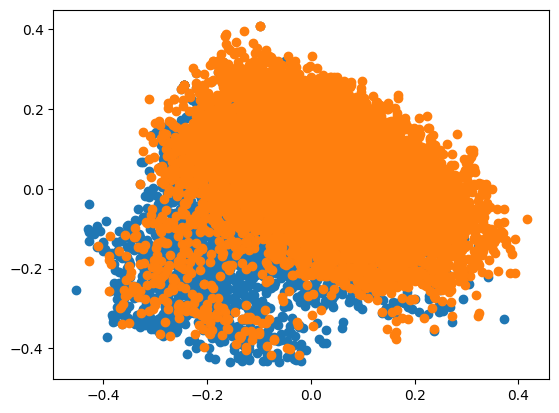

In [ ]:


pca = PCA(n_components=2)
pca.fit(np.concatenate([comments_tr_human_embs, comments_tr_machine_embs], axis=0))

comments_tr_human_embs_pcs = pca.transform(comments_tr_human_embs)
comments_tr_machine_embs_pcs = pca.transform(comments_tr_machine_embs)

plt.scatter(comments_tr_human_embs_pcs[:, 0], comments_tr_human_embs_pcs[:, 1])
plt.scatter(comments_tr_machine_embs_pcs[:, 0], comments_tr_machine_embs_pcs[:, 1])
plt.show()




In [34]:
flatten_list([[t for t, b in tbs if b == "Punctuation"] for tbs in tqdm(D_machine_tr["text_base"])])

100%|██████████| 5244/5244 [00:00<00:00, 69681.39it/s]


['(',
 ',',
 ',',
 ')',
 ':',
 '[',
 '(',
 ',',
 ')',
 ',',
 '(',
 ',',
 ')',
 ',',
 '(',
 ',',
 ')',
 ']',
 '(',
 '(',
 ')',
 ')',
 '(',
 '(',
 ',',
 ',',
 ')',
 ')',
 '(',
 ',',
 ')',
 ':',
 ':',
 '(',
 '(',
 ',',
 ')',
 ')',
 ',',
 ':',
 ',',
 ',',
 '(',
 ',',
 ')',
 ':',
 '[',
 ']',
 '[',
 ']',
 '(',
 ',',
 ')',
 '(',
 ',',
 ')',
 '(',
 '(',
 ',',
 ')',
 ')',
 ':',
 '(',
 ',',
 '(',
 ',',
 ')',
 ')',
 '(',
 ')',
 ':',
 ':',
 ',',
 '(',
 ',',
 ')',
 '(',
 ')',
 '(',
 ')',
 ':',
 ':',
 '(',
 ')',
 '(',
 ')',
 '(',
 '(',
 ')',
 ')',
 '(',
 ')',
 ':',
 '(',
 ')',
 '(',
 ')',
 ':',
 ',',
 '[',
 ':',
 ']',
 '(',
 ')',
 ',',
 '(',
 ')',
 ',',
 '(',
 ')',
 '(',
 ')',
 '(',
 '(',
 ')',
 ')',
 ':',
 ':',
 '(',
 ')',
 ':',
 ':',
 '(',
 ')',
 '(',
 ')',
 '(',
 '(',
 ')',
 '(',
 ')',
 ')',
 '(',
 ')',
 ':',
 ',',
 '(',
 ',',
 '(',
 ')',
 '(',
 ')',
 ')',
 '{',
 '}',
 '(',
 ')',
 ':',
 ',',
 '(',
 ')',
 '(',
 ')',
 '[',
 ']',
 '[',
 ']',
 '(',
 ')',
 '(',
 ')',
 ':',
 '(',
 ',',
 '[',
 ']',
 ','

In [35]:
# Build features
len(Counter(flatten_list(D_tr["text_base"].to_list())))

69742

In [69]:
def identity_fn(x):
    return x

plid_vectorizer = TfidfVectorizer(
    vocabulary=VOCAB_FOR_PLID,
    analyzer=identity_fn,
    lowercase=False,
    norm=None,
    use_idf=True,
    smooth_idf=True,
).fit(D_tr["text_base"].to_list())

In [70]:
X_tr = plid_vectorizer.transform(D_tr["text_base"].to_list())
X_ev = plid_vectorizer.transform(D_ev["text_base"].to_list())

In [71]:
plid = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=1000,
    random_state=888,
).fit(X_tr, D_tr["language"])

In [72]:
print(classification_report(D_ev["language"], plid.predict(X_ev)))

              precision    recall  f1-score   support

         C++       0.98      0.97      0.98       459
        Java       0.97      0.97      0.97       413
      Python       1.00      1.00      1.00      9128

    accuracy                           1.00     10000
   macro avg       0.99      0.98      0.98     10000
weighted avg       1.00      1.00      1.00     10000



In [ ]:
for lang in D_tr["language"].unique():
    D_tr_sub = D_tr[D_tr["language"] == lang]

    

Python
Java
C++


In [57]:
len(VOCAB_FOR_PLID)

132

In [38]:
D_tr

,code,generator,label,language,token_obj,tokens,base_type,text,base,text_base
361965,t = int(input())\nfor _ in range(t):\n\tk = [l...,human,0,Python,"{'language': 'Python', 'tokens': [{'text': 't'...","[{'text': 't', 'type': 'Token.Name', 'base_typ...","[Name, Text, Operator, Text, Name, Punctuation...","[t, , =, , int, (, input, (, ), ), \n, for, ...","[Name, Text, Operator, Text, Name, Punctuation...","[t<->Name, <->Text, =<->Operator, <->Text, i..."
179837,import static java.lang.Math.max;\n\nimport st...,human,0,Java,"{'language': 'Java', 'tokens': [{'text': 'impo...","[{'text': 'import static', 'type': 'Token.Keyw...","[Keyword, Text, Name, Punctuation, Text, Text,...","[import static, , java.lang.Math.max, ;, \n, ...","[Keyword, Text, Name, Punctuation, Text, Text,...","[import static<->Keyword, <->Text, java.lang...."
472639,"(n, *a) = map(int, open(0).read().split())\nm ...",human,0,Python,"{'language': 'Python', 'tokens': [{'text': '('...","[{'text': '(', 'type': 'Token.Punctuation', 'b...","[Punctuation, Name, Punctuation, Text, Operato...","[(, n, ,, , *, a, ), , =, , map, (, int, ,,...","[Punctuation, Name, Punctuation, Text, Operato...","[(<->Punctuation, n<->Name, ,<->Punctuation, ..."
97298,from collections import defaultdict\n\ndef are...,human,0,Python,"{'language': 'Python', 'tokens': [{'text': 'fr...","[{'text': 'from', 'type': 'Token.Keyword.Names...","[Keyword, Text, Name, Text, Keyword, Text, Nam...","[from, , collections, , import, , defaultdi...","[Keyword, Text, Name, Text, Keyword, Text, Nam...","[from<->Keyword, <->Text, collections<->Name,..."
276933,"n = int(input())\n(v, a) = ([0] * n, [0] * n)\...",human,0,Python,"{'language': 'Python', 'tokens': [{'text': 'n'...","[{'text': 'n', 'type': 'Token.Name', 'base_typ...","[Name, Text, Operator, Text, Name, Punctuation...","[n, , =, , int, (, input, (, ), ), \n, (, v,...","[Name, Text, Operator, Text, Name, Punctuation...","[n<->Name, <->Text, =<->Operator, <->Text, i..."
...,...,...,...,...,...,...,...,...,...,...
448969,bisect.bisect_left can be helpful in finding v...,microsoft/phi-2,1,Python,"{'language': 'Python', 'tokens': [{'text': 'bi...","[{'text': 'bisect', 'type': 'Token.Name', 'bas...","[Name, Operator, Name, Text, Name, Text, Name,...","[bisect, ., bisect_left, , can, , be, , hel...","[Name, Operator, Name, Text, Name, Text, Name,...","[bisect<->Name, .<->Operator, bisect_left<->Na..."
416400,", don't print anything.\ndef beautiful_string_...",Qwen/Qwen2.5-Coder-1.5B,1,Python,"{'language': 'Python', 'tokens': [{'text': ','...","[{'text': ',', 'type': 'Token.Punctuation', 'b...","[Punctuation, Text, Name, Literal, Literal, Te...","[,, , don, ', t print anything., \n, def, , ...","[Punctuation, Text, Name, Literal, Literal, Te...","[,<->Punctuation, <->Text, don<->Name, '<->Li..."
61662,const int MAXN = 300005;\n\nnamespace Trie {\n...,human,0,C++,"{'language': 'C++', 'tokens': [{'text': 'const...","[{'text': 'const', 'type': 'Token.Keyword', 'b...","[Keyword, Text, Keyword, Text, Name, Text, Ope...","[const, , int, , MAXN, , =, , 300005, ;, \...","[Keyword, Text, Keyword, Text, Name, Text, Ope...","[const<->Keyword, <->Text, int<->Keyword, <-..."
337637,python\n\ndef min_rectangle_cover(points):\n ...,01-ai/Yi-Coder-9B-Chat,1,Python,"{'language': 'Python', 'tokens': [{'text': 'py...","[{'text': 'python', 'type': 'Token.Name', 'bas...","[Name, Text, Text, Keyword, Text, Name, Punctu...","[python, \n, \n, def, , min_rectangle_cover, ...","[Name, Text, Text, Keyword, Text, Name, Punctu...","[python<->Name, \n<->Text, \n<->Text, def<->Ke..."


In [36]:
flatten_list(D_tr["text_base"].to_list())

['t<->Name',
 ' <->Text',
 '=<->Operator',
 ' <->Text',
 'int<->Name',
 '(<->Punctuation',
 'input<->Name',
 '(<->Punctuation',
 ')<->Punctuation',
 ')<->Punctuation',
 '\n<->Text',
 'for<->Keyword',
 ' <->Text',
 '_<->Name',
 ' <->Text',
 'in<->Operator',
 ' <->Text',
 'range<->Name',
 '(<->Punctuation',
 't<->Name',
 ')<->Punctuation',
 ':<->Punctuation',
 '\n<->Text',
 '\t<->Text',
 'k<->Name',
 ' <->Text',
 '=<->Operator',
 ' <->Text',
 '[<->Punctuation',
 'len<->Name',
 '(<->Punctuation',
 'x<->Name',
 ')<->Punctuation',
 ' <->Text',
 'for<->Keyword',
 ' <->Text',
 'x<->Name',
 ' <->Text',
 'in<->Operator',
 ' <->Text',
 'input<->Name',
 '(<->Punctuation',
 ')<->Punctuation',
 '.<->Operator',
 'split<->Name',
 '(<->Punctuation',
 "'<->Literal",
 'R<->Literal',
 "'<->Literal",
 ')<->Punctuation',
 ']<->Punctuation',
 '\n<->Text',
 '\t<->Text',
 'print<->Name',
 '(<->Punctuation',
 'max<->Name',
 '(<->Punctuation',
 'k<->Name',
 ')<->Punctuation',
 ' <->Text',
 '+<->Operator',
 ' <-

In [ ]:
# Build pLID

In [32]:
D_tr

,code,generator,label,language,token_obj,tokens,base_type,text,base,text_base
361965,t = int(input())\nfor _ in range(t):\n\tk = [l...,human,0,Python,"{'language': 'Python', 'tokens': [{'text': 't'...","[{'text': 't', 'type': 'Token.Name', 'base_typ...","[Name, Text, Operator, Text, Name, Punctuation...","[t, , =, , int, (, input, (, ), ), \n, for, ...","[Name, Text, Operator, Text, Name, Punctuation...","[t<->Name, <->Text, =<->Operator, <->Text, i..."
179837,import static java.lang.Math.max;\n\nimport st...,human,0,Java,"{'language': 'Java', 'tokens': [{'text': 'impo...","[{'text': 'import static', 'type': 'Token.Keyw...","[Keyword, Text, Name, Punctuation, Text, Text,...","[import static, , java.lang.Math.max, ;, \n, ...","[Keyword, Text, Name, Punctuation, Text, Text,...","[import static<->Keyword, <->Text, java.lang...."
472639,"(n, *a) = map(int, open(0).read().split())\nm ...",human,0,Python,"{'language': 'Python', 'tokens': [{'text': '('...","[{'text': '(', 'type': 'Token.Punctuation', 'b...","[Punctuation, Name, Punctuation, Text, Operato...","[(, n, ,, , *, a, ), , =, , map, (, int, ,,...","[Punctuation, Name, Punctuation, Text, Operato...","[(<->Punctuation, n<->Name, ,<->Punctuation, ..."
97298,from collections import defaultdict\n\ndef are...,human,0,Python,"{'language': 'Python', 'tokens': [{'text': 'fr...","[{'text': 'from', 'type': 'Token.Keyword.Names...","[Keyword, Text, Name, Text, Keyword, Text, Nam...","[from, , collections, , import, , defaultdi...","[Keyword, Text, Name, Text, Keyword, Text, Nam...","[from<->Keyword, <->Text, collections<->Name,..."
276933,"n = int(input())\n(v, a) = ([0] * n, [0] * n)\...",human,0,Python,"{'language': 'Python', 'tokens': [{'text': 'n'...","[{'text': 'n', 'type': 'Token.Name', 'base_typ...","[Name, Text, Operator, Text, Name, Punctuation...","[n, , =, , int, (, input, (, ), ), \n, (, v,...","[Name, Text, Operator, Text, Name, Punctuation...","[n<->Name, <->Text, =<->Operator, <->Text, i..."
...,...,...,...,...,...,...,...,...,...,...
448969,bisect.bisect_left can be helpful in finding v...,microsoft/phi-2,1,Python,"{'language': 'Python', 'tokens': [{'text': 'bi...","[{'text': 'bisect', 'type': 'Token.Name', 'bas...","[Name, Operator, Name, Text, Name, Text, Name,...","[bisect, ., bisect_left, , can, , be, , hel...","[Name, Operator, Name, Text, Name, Text, Name,...","[bisect<->Name, .<->Operator, bisect_left<->Na..."
416400,", don't print anything.\ndef beautiful_string_...",Qwen/Qwen2.5-Coder-1.5B,1,Python,"{'language': 'Python', 'tokens': [{'text': ','...","[{'text': ',', 'type': 'Token.Punctuation', 'b...","[Punctuation, Text, Name, Literal, Literal, Te...","[,, , don, ', t print anything., \n, def, , ...","[Punctuation, Text, Name, Literal, Literal, Te...","[,<->Punctuation, <->Text, don<->Name, '<->Li..."
61662,const int MAXN = 300005;\n\nnamespace Trie {\n...,human,0,C++,"{'language': 'C++', 'tokens': [{'text': 'const...","[{'text': 'const', 'type': 'Token.Keyword', 'b...","[Keyword, Text, Keyword, Text, Name, Text, Ope...","[const, , int, , MAXN, , =, , 300005, ;, \...","[Keyword, Text, Keyword, Text, Name, Text, Ope...","[const<->Keyword, <->Text, int<->Keyword, <-..."
337637,python\n\ndef min_rectangle_cover(points):\n ...,01-ai/Yi-Coder-9B-Chat,1,Python,"{'language': 'Python', 'tokens': [{'text': 'py...","[{'text': 'python', 'type': 'Token.Name', 'bas...","[Name, Text, Text, Keyword, Text, Name, Punctu...","[python, \n, \n, def, , min_rectangle_cover, ...","[Name, Text, Text, Keyword, Text, Name, Punctu...","[python<->Name, \n<->Text, \n<->Text, def<->Ke..."


In [25]:
Counter(flatten_list(D_tr["base_type"].to_list()))

Counter({'Text': 1285889,
         'Name': 741223,
         'Punctuation': 716371,
         'Operator': 393538,
         'Literal': 268842,
         'Keyword': 139774,
         'Comment': 24032,
         'Error': 9882})

In [26]:
Counter(flatten_list(D_ev["base_type"].to_list()))

Counter({'Text': 1276265,
         'Name': 733407,
         'Punctuation': 715175,
         'Operator': 386844,
         'Literal': 264753,
         'Keyword': 137690,
         'Comment': 22545,
         'Error': 9876})

In [ ]:
# Predict language
D_tr["language_pred"] = [
    lang_detector.identify_bytes(f"{code}".encode('utf-8')).output.label
    for code in tqdm(D_tr["code"], total=len(D_tr))
]

D_ev["language_pred"] = [
    lang_detector.identify_bytes(f"{code}".encode('utf-8')).output.label
    for code in tqdm(D_ev["code"], total=len(D_ev))
]

D_te["language_pred"] = [
    lang_detector.identify_bytes(f"{code}".encode('utf-8')).output.label
    for code in tqdm(D_te["code"], total=len(D_te))
]

100%|██████████| 1000/1000 [00:03<00:00, 307.83it/s]


In [ ]:
semeval2pygment_ids = {
    "C++": "cpp",
    "Python": "python",
    "Java": "java",
    "Go": "go",
    "PHP": "php",
    "C#": "c#",
    "C": "c",
    "JS": "javascript",
}

In [23]:
# Tokenize code
D_tr["token_obj"] = [tokenize_code(code, language=lang) for code, lang in tqdm(zip(D_tr["code"], D_tr["language"]), total=len(D_tr))]
D_tr["tokens"] = [obj["tokens"] for obj in D_tr["token_obj"]]

D_ev["token_obj"] = [tokenize_code(code, possible_languages=semeval2pygment_ids.values()) for code, lang in tqdm(zip(D_ev["code"], D_ev["language"]), total=len(D_ev))]
D_ev["tokens"] = [obj["tokens"] for obj in D_ev["token_obj"]]

D_te["token_obj"] = [tokenize_code(code, possible_languages=semeval2pygment_ids.values()) for code, lang in tqdm(zip(D_te["code"], D_te["language"]), total=len(D_te))]
D_te["tokens"] = [obj["tokens"] for obj in D_te["token_obj"]]

100%|██████████| 1000/1000 [00:01<00:00, 849.96it/s]


In [29]:
D_ev["language"]

24602    python
94229      java
64802    python
7583     python
16997      java
          ...  
63690    python
59449    python
19887    python
81512    python
80226    python
Name: language, Length: 10000, dtype: object

In [32]:
D_ev["token_obj"].apply(lambda x: semeval2pygment_ids[x["language"]])

24602       c++
94229       c++
64802       c++
7583        c++
16997    python
          ...  
63690    python
59449       c++
19887       c++
81512    python
80226       c++
Name: token_obj, Length: 10000, dtype: object

In [34]:
!pip install magika

  Using cached python_dotenv-1.2.1-py3-none-any.whl.metadata (25 kB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached humanfriendly-10.0-py2.py3-none-any.whl.metadata (9.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 15.8 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 24.5 MB/s  0:00:00 eta 0:00:01
Using cached python_dotenv-1.2.1-py3-none-any.whl (21 kB)
Using cached coloredlogs-15.0.1-py2.py3-none-any.whl (46 kB)
Using cached humanfriendly-10.0-py2.py3-none-any.whl (86 kB)
Using cached flatbuffers-25.9.23-py2.py3-none-any.whl (30 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [magika]2m4/6 [onnxruntime]


In [36]:
m = Magika()
res = m.identify_bytes(b'function log(msg) {console.log(msg);}')
print(res.output.label)

javascript


In [33]:
print(classification_report(D_ev["language"], D_ev["token_obj"].apply(lambda x: semeval2pygment_ids[x["language"]])))

              precision    recall  f1-score   support

           c       0.00      0.00      0.00         0
         c++       0.06      0.97      0.11       451
        java       0.00      0.00      0.00       384
         php       0.00      0.00      0.00         0
      python       0.93      0.26      0.40      9165

    accuracy                           0.28     10000
   macro avg       0.20      0.24      0.10     10000
weighted avg       0.86      0.28      0.37     10000



/Users/rendvvv/miniconda3/envs/lingu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rendvvv/miniconda3/envs/lingu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/rendvvv/miniconda3/envs/lingu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [18]:
sample["tokens"]

[{'text': 'def', 'type': 'Token.Keyword', 'base_type': 'Keyword'},
 {'text': ' ', 'type': 'Token.Text.Whitespace', 'base_type': 'Text'},
 {'text': 'range_search', 'type': 'Token.Name.Function', 'base_type': 'Name'},
 {'text': '(', 'type': 'Token.Punctuation', 'base_type': 'Punctuation'},
 {'text': 'points', 'type': 'Token.Name', 'base_type': 'Name'},
 {'text': ',', 'type': 'Token.Punctuation', 'base_type': 'Punctuation'},
 {'text': ' ', 'type': 'Token.Text', 'base_type': 'Text'},
 {'text': 'queries', 'type': 'Token.Name', 'base_type': 'Name'},
 {'text': ')', 'type': 'Token.Punctuation', 'base_type': 'Punctuation'},
 {'text': ':', 'type': 'Token.Punctuation', 'base_type': 'Punctuation'},
 {'text': '\n', 'type': 'Token.Text.Whitespace', 'base_type': 'Text'},
 {'text': '    ', 'type': 'Token.Text', 'base_type': 'Text'},
 {'text': 'results', 'type': 'Token.Name', 'base_type': 'Name'},
 {'text': ' ', 'type': 'Token.Text', 'base_type': 'Text'},
 {'text': '=', 'type': 'Token.Operator', 'base_

In [8]:
# Your input code string
code_snippet = """class Solution:

\tdef maximumSum(self, arr: List[int]) -> int:
\t\tr = max(arr)
\t\tif r < 0:
\t\t\treturn r
\t\tl = len(arr)
\t\tf = [0] * l
\t\tb = [0] * l
\t\tcur = 0
\t\tfor i in range(l):
\t\t\tf[i] = cur
\t\t\tcur += arr[i]
\t\t\tcur = max(cur, 0)
\t\tcur = 0
\t\tfor i in range(l - 1, -1, -1):
\t\t\tb[i] = cur
\t\t\tcur += arr[i]
\t\t\tcur = max(cur, 0)
\t\treturn max((f[i] + b[i] for i in range(l)))
"""

def tokenize_code(code):
    # The lex() function returns a generator of (token_type, value) tuples
    tokens = list(lex(code, PythonLexer()))
    
    print(f"{'Token Type':<30} | {'Value (repr)':<20}")
    print("-" * 55)
    
    for token_type, value in tokens:
        # We use repr(value) to see hidden characters like \t and \n clearly
        print(f"{str(token_type):<30} | {repr(value):<20}")

tokenize_code(code_snippet)

Token Type                     | Value (repr)        
-------------------------------------------------------
Token.Keyword                  | 'class'             
Token.Text.Whitespace          | ' '                 
Token.Name.Class               | 'Solution'          
Token.Punctuation              | ':'                 
Token.Text.Whitespace          | '\n'                
Token.Text.Whitespace          | '\n'                
Token.Text                     | '\t'                
Token.Keyword                  | 'def'               
Token.Text.Whitespace          | ' '                 
Token.Name.Function            | 'maximumSum'        
Token.Punctuation              | '('                 
Token.Name.Builtin.Pseudo      | 'self'              
Token.Punctuation              | ','                 
Token.Text                     | ' '                 
Token.Name                     | 'arr'               
Token.Punctuation              | ':'                 
Token.Text                

In [54]:
tokenizer = AutoTokenizer.from_pretrained("bigcode/starcoder")

In [58]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Coder-32B-Instruct")

(500000, 4) (100000, 4) (1000, 4)


,code,generator,label,language
0,"(a, b, c, d) = [int(x) for x in input().split(...",human,0,Python
1,valid version for the language; all others can...,Qwen/Qwen2.5-Coder-1.5B,1,Python


In [63]:
sample = D_tr.sample().iloc[0]

print(sample["code"])

class Solution:

	def maximumSum(self, arr: List[int]) -> int:
		r = max(arr)
		if r < 0:
			return r
		l = len(arr)
		f = [0] * l
		b = [0] * l
		cur = 0
		for i in range(l):
			f[i] = cur
			cur += arr[i]
			cur = max(cur, 0)
		cur = 0
		for i in range(l - 1, -1, -1):
			b[i] = cur
			cur += arr[i]
			cur = max(cur, 0)
		return max((f[i] + b[i] for i in range(l)))



In [75]:
from nltk import ngrams, word_tokenize

In [86]:
!pip install Pygments

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
sample["code"]

'class Solution:\n\n\tdef maximumSum(self, arr: List[int]) -> int:\n\t\tr = max(arr)\n\t\tif r < 0:\n\t\t\treturn r\n\t\tl = len(arr)\n\t\tf = [0] * l\n\t\tb = [0] * l\n\t\tcur = 0\n\t\tfor i in range(l):\n\t\t\tf[i] = cur\n\t\t\tcur += arr[i]\n\t\t\tcur = max(cur, 0)\n\t\tcur = 0\n\t\tfor i in range(l - 1, -1, -1):\n\t\t\tb[i] = cur\n\t\t\tcur += arr[i]\n\t\t\tcur = max(cur, 0)\n\t\treturn max((f[i] + b[i] for i in range(l)))\n'

In [84]:
def get_bow_ngrams_from_doc(text, n=1):
    tokens = [word for word in text.split(" ")]
    tokens = list(ngrams(tokens, n=n))
    tokens = [" ".join(token) for token in tokens]
    return tokens

In [85]:
get_bow_ngrams_from_doc(sample["code"])

['class',
 'Solution:\n\n\tdef',
 'maximumSum(self,',
 'arr:',
 'List[int])',
 '->',
 'int:\n\t\tr',
 '=',
 'max(arr)\n\t\tif',
 'r',
 '<',
 '0:\n\t\t\treturn',
 'r\n\t\tl',
 '=',
 'len(arr)\n\t\tf',
 '=',
 '[0]',
 '*',
 'l\n\t\tb',
 '=',
 '[0]',
 '*',
 'l\n\t\tcur',
 '=',
 '0\n\t\tfor',
 'i',
 'in',
 'range(l):\n\t\t\tf[i]',
 '=',
 'cur\n\t\t\tcur',
 '+=',
 'arr[i]\n\t\t\tcur',
 '=',
 'max(cur,',
 '0)\n\t\tcur',
 '=',
 '0\n\t\tfor',
 'i',
 'in',
 'range(l',
 '-',
 '1,',
 '-1,',
 '-1):\n\t\t\tb[i]',
 '=',
 'cur\n\t\t\tcur',
 '+=',
 'arr[i]\n\t\t\tcur',
 '=',
 'max(cur,',
 '0)\n\t\treturn',
 'max((f[i]',
 '+',
 'b[i]',
 'for',
 'i',
 'in',
 'range(l)))\n']

In [59]:
tokenizer.tokenize(sample["code"])

['def',
 'Ġnth',
 'Mag',
 'ical',
 'Number',
 '(N',
 ':',
 'Ġint',
 ',',
 'ĠA',
 ':',
 'Ġint',
 ',',
 'ĠB',
 ':',
 'Ġint',
 ')',
 'Ġ->',
 'Ġint',
 ':Ċ',
 'ĠĠĠ',
 'ĠMOD',
 'Ġ=',
 'Ġ',
 '1',
 '0',
 '**',
 '9',
 'Ġ+',
 'Ġ',
 '7',
 'Ċ',
 'ĠĠĠ',
 'Ġdef',
 'Ġgcd',
 '(a',
 ',',
 'Ġb',
 '):Ċ',
 'ĠĠĠĠĠĠĠ',
 'Ġwhile',
 'Ġb',
 ':Ċ',
 'ĠĠĠĠĠĠĠĠĠĠĠ',
 'Ġa',
 ',',
 'Ġb',
 'Ġ=',
 'Ġb',
 ',',
 'Ġa',
 'Ġ%',
 'Ġb',
 'Ċ',
 'ĠĠĠĠĠĠĠ',
 'Ġreturn',
 'Ġa',
 'ĊĊ',
 'ĠĠĠ',
 'Ġdef',
 'Ġlcm',
 '(a',
 ',',
 'Ġb',
 '):Ċ',
 'ĠĠĠĠĠĠĠ',
 'Ġreturn',
 'Ġa',
 'Ġ*',
 'Ġb',
 'Ġ//',
 'Ġgcd',
 '(a',
 ',',
 'Ġb',
 ')ĊĊ',
 'ĠĠĠ',
 'Ġleft',
 ',',
 'Ġright',
 'Ġ=',
 'Ġmin',
 '(A',
 ',',
 'ĠB',
 '),',
 'ĠN',
 'Ġ*',
 'Ġmin',
 '(A',
 ',',
 'ĠB',
 ')Ċ',
 'ĠĠĠ',
 'Ġwhile',
 'Ġleft',
 'Ġ<',
 'Ġright',
 ':Ċ',
 'ĠĠĠĠĠĠĠ',
 'Ġmid',
 'Ġ=',
 'Ġ(',
 'left',
 'Ġ+',
 'Ġright',
 ')',
 'Ġ//',
 'Ġ',
 '2',
 'Ċ',
 'ĠĠĠĠĠĠĠ',
 'Ġif',
 'Ġmid',
 'Ġ//',
 'ĠA',
 'Ġ+',
 'Ġmid',
 'Ġ//',
 'ĠB',
 'Ġ-',
 'Ġmid',
 'Ġ//',
 'Ġlcm',
 '(A',
 ',',
 'ĠB',
 ')',
 

In [51]:
print(sample["generator"])

meta-llama/Llama-3.3-70B-Instruct


In [13]:
Counter(D_ev["language"])

Counter({'Python': 91461, 'C++': 4679, 'Java': 3860})

In [14]:
Counter(D_te["language"])

Counter({'Python': 303,
         'Java': 256,
         'C#': 122,
         'JavaScript': 85,
         'C++': 75,
         'Go': 60,
         'C': 51,
         'PHP': 48})

In [15]:
D_te

,code,generator,label,language
0,public Vector To(Vector o)\n {\n ...,Human,0,C#
1,func (v *DefaultMessageSyntaxValidator) Valida...,Human,0,Go
2,"""""""Module managing testsuite capabilities\n\nC...",Human,0,Python
3,void Anvil::Image::on_memory_backing_opaque_up...,Human,0,C++
4,bool NOMAD::Priority_Eval_Point::dominates\n( ...,Human,0,C++
...,...,...,...,...
995,/**-------------------------------------------...,Human,0,C
996,"void AuxFunc(const dTensor1& xpts, \n\t dT...",Human,0,C++
997,def plot_confusion_matrix(\n context: MLCli...,Human,0,Python
998,import sys\nfrom collections import Counter\n\...,human,0,Python
